# Фаза 1. Неделя 4
## Обучение без учителя
### Временные ряды

In [1]:
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (18, 5)

In [2]:
# Загружаем данные, ставим в индекс колонку с датой, указыываем аргумент parse_dates
df = pd.read_csv('aux/monthly-milk-production.csv',
                 sep=';', 
                 index_col=['month'],
                 parse_dates=['month'], 
                 dayfirst=True
                )

In [3]:
df

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


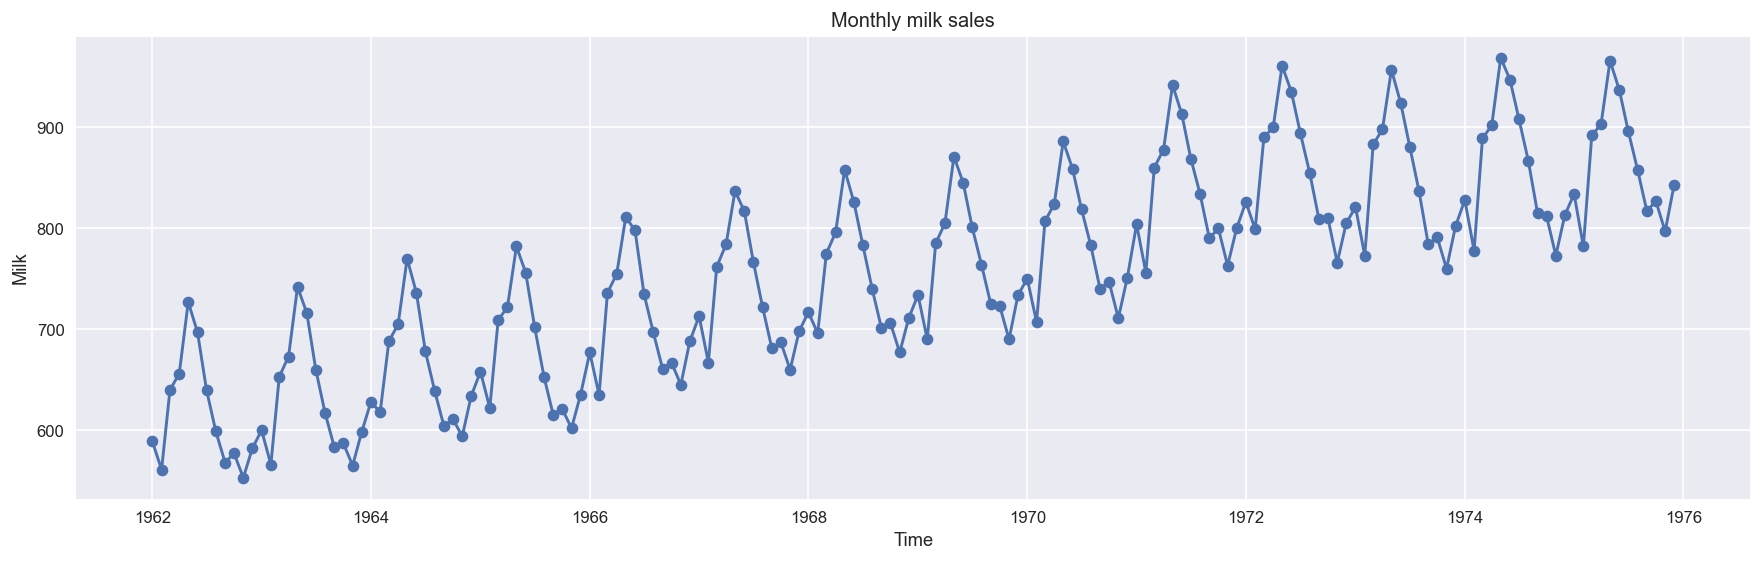

In [4]:
plt.plot(df['milk'], marker='o')
plt.xlabel('Time')
plt.ylabel('Milk')
plt.title('Monthly milk sales');

In [5]:
# Обращаем внимание: тип индекса datetime64[ns]
df.index

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '1975-03-01', '1975-04-01', '1975-05-01', '1975-06-01',
               '1975-07-01', '1975-08-01', '1975-09-01', '1975-10-01',
               '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='month', length=168, freq=None)

In [6]:
# выбрать сэмпл с определенным годом
df.loc[df.index.year == 1975]

,milk
month,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966
1975-06-01,937
1975-07-01,896
1975-08-01,858
1975-09-01,817


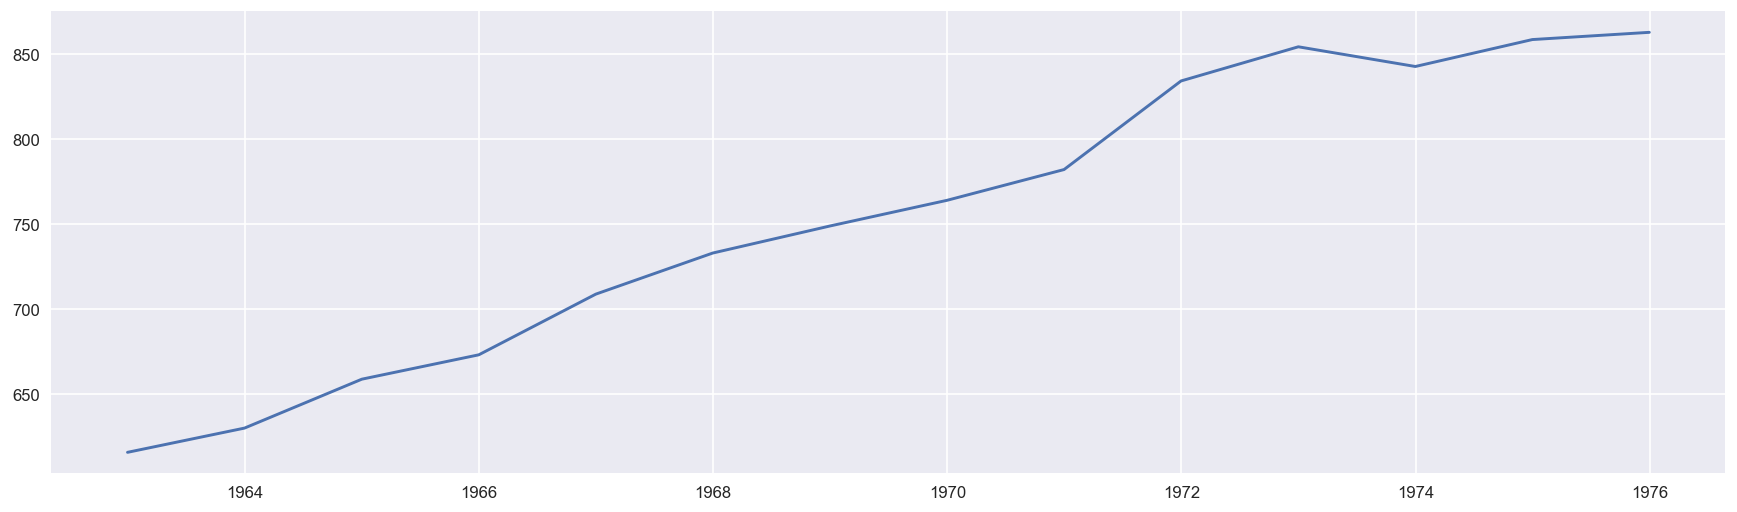

In [7]:
# resample позоволяет взять выборку по определенному интервалу и посчитать необходимую статистику
# display(df.resample('Y').sum())
# display(df.resample('Y').mean())
plt.plot(df.resample('Y').mean());

### 1.1 Скользящее среднее / Moving Average

$\hat{y}_{t} = \dfrac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

In [8]:
df.head()

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


* Попробуем скользящее окно размером 1. а-ля предсказание вида "Завтра будет как вчера"

In [9]:
n_window = 1

moving_average_pred = df['milk'].rolling(window=n_window, closed='left').mean()

moving_average_mae = np.round(mean_absolute_error(df['milk'][n_window:], moving_average_pred[n_window:]), 2)
moving_average_r2 = np.round(r2_score(df['milk'][n_window:], moving_average_pred[n_window:]), 2)

'MAE = 39.01'

'r2 = 0.8'

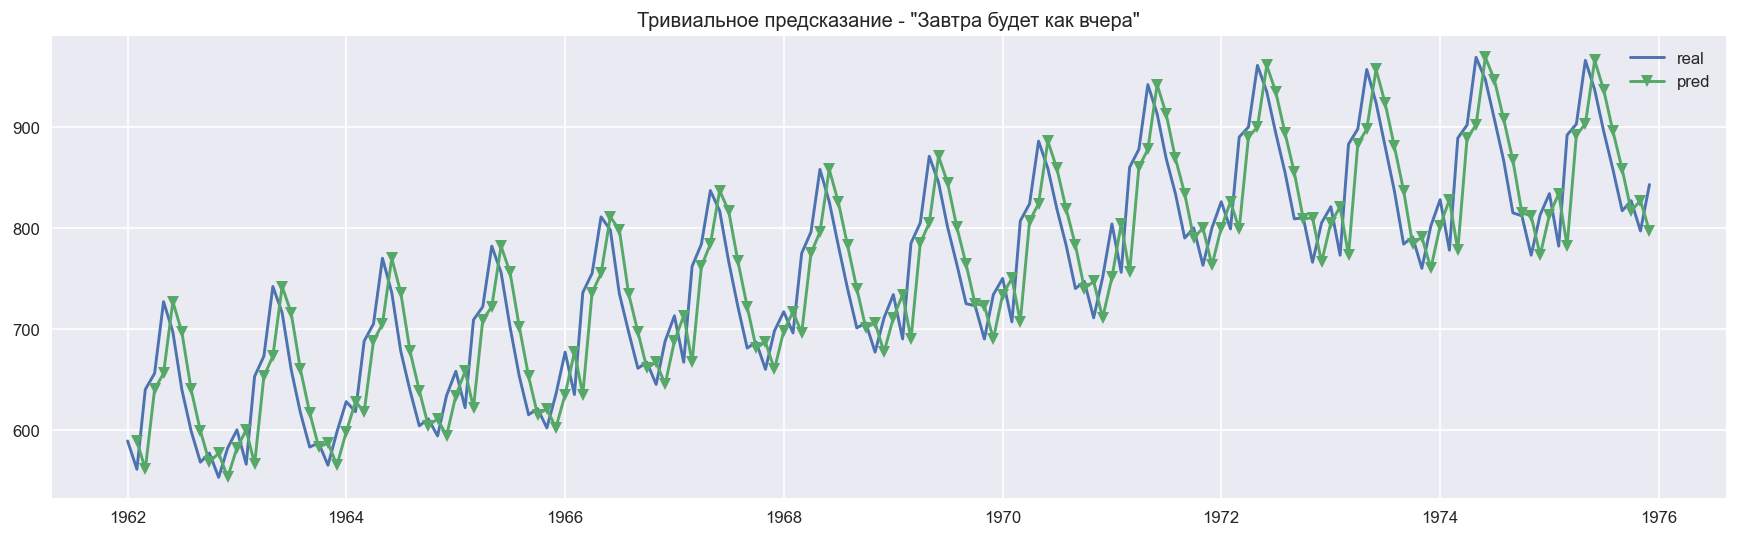

In [10]:
display(f'MAE = {moving_average_mae}')
display(f'r2 = {moving_average_r2}')
plt.plot(df['milk'], label='real')
plt.plot(moving_average_pred, label='pred', marker='v')
plt.legend()
plt.title(f'Тривиальное предсказание - "Завтра будет как вчера"');

* Посмотрим для окон разных размеров

In [11]:
n_windows = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for n_window in n_windows:
    rolling_pred = pd.DataFrame(data={'act': df['milk'], 'pred': df['milk'].rolling(window=n_window, closed='left').mean()})
    mae = np.round(mean_absolute_error(rolling_pred['act'][n_window:], rolling_pred['pred'][n_window:]), 2)
    print(f'Для скользящего окна размером {n_window}, MAE = {mae}')

Для скользящего окна размером 1, MAE = 39.01
Для скользящего окна размером 2, MAE = 45.08
Для скользящего окна размером 3, MAE = 52.78
Для скользящего окна размером 4, MAE = 59.77
Для скользящего окна размером 5, MAE = 61.9
Для скользящего окна размером 6, MAE = 64.3
Для скользящего окна размером 7, MAE = 66.06
Для скользящего окна размером 8, MAE = 66.37
Для скользящего окна размером 9, MAE = 64.27
Для скользящего окна размером 10, MAE = 60.29
Для скользящего окна размером 11, MAE = 55.77
Для скользящего окна размером 12, MAE = 51.28
Для скользящего окна размером 13, MAE = 48.66
Для скользящего окна размером 14, MAE = 47.49
Для скользящего окна размером 15, MAE = 48.22


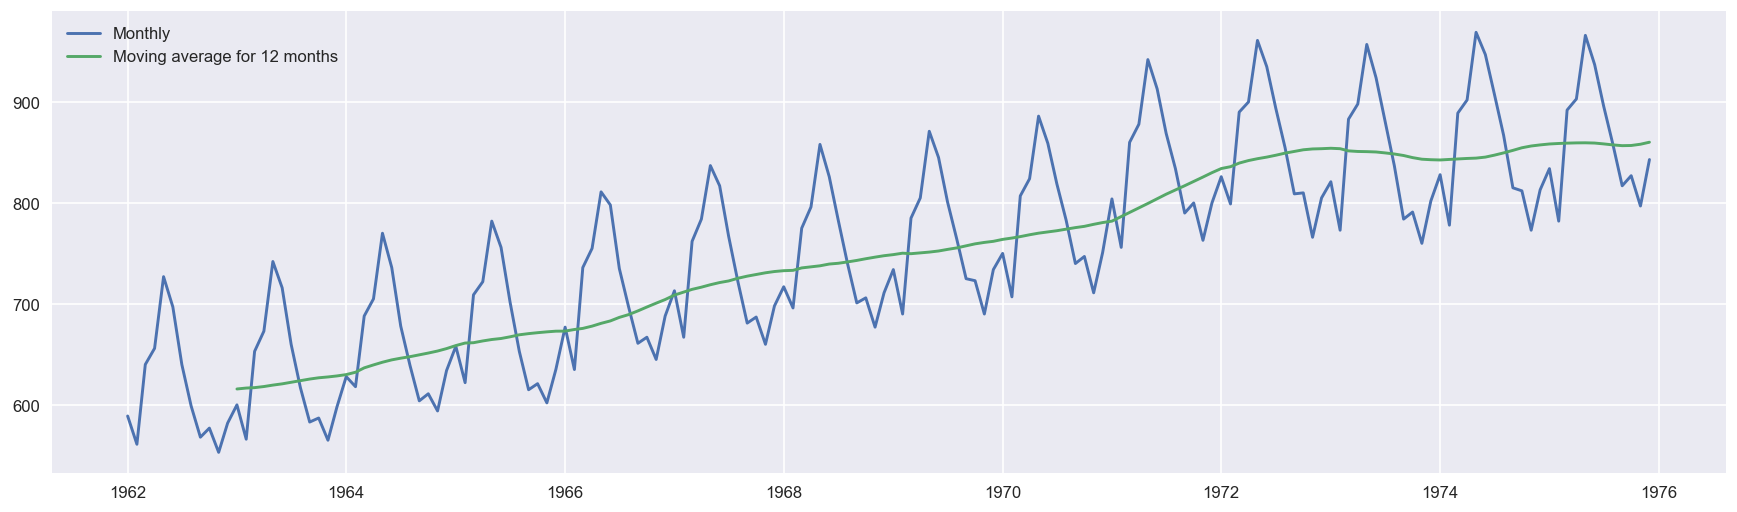

In [12]:
n_months = 12

plt.plot(df['milk'], label='Monthly')
plt.plot(df['milk'].rolling(window=n_months, closed='left').mean(), 
         label=f'Moving average for {n_months} months')
plt.legend();

### 1.2 Взвешенное скользящее среднее / Weighted moving average

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [13]:
# Функция взвешенного скользязщего среднего, веса нормируются в коде
def weighted_moving_average(x, n, weights):
    weights = np.array(weights) # веса
    wmas = x.rolling(n).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True).to_list() # 
    result = pd.Series(wmas, index=df.index).shift(1)
    return result

In [14]:
n_window = 12

# вес 0.7 для значений 12 месяцев назад, следующие десять месяцев по 0.01 и 0.2 последний месяц
weights = [0.7] * 1 + [0.1 / 10] * 10 + [0.2] * 1

weighted_moving_average_pred = weighted_moving_average(df['milk'], n=n_window, weights=weights)


weighted_moving_average_mae = np.round(
    mean_absolute_error(
        df['milk'][n_window:],
        weighted_moving_average_pred[n_window:]
    ),
    2
)
weighted_moving_average_r2 = np.round(
    r2_score(
        df['milk'][n_window:],
        weighted_moving_average_pred[n_window:],
    ),
    2
)

display(f'MAE = {weighted_moving_average_mae}')
display(f'r2 = {weighted_moving_average_r2}')

'MAE = 18.88'

'r2 = 0.94'

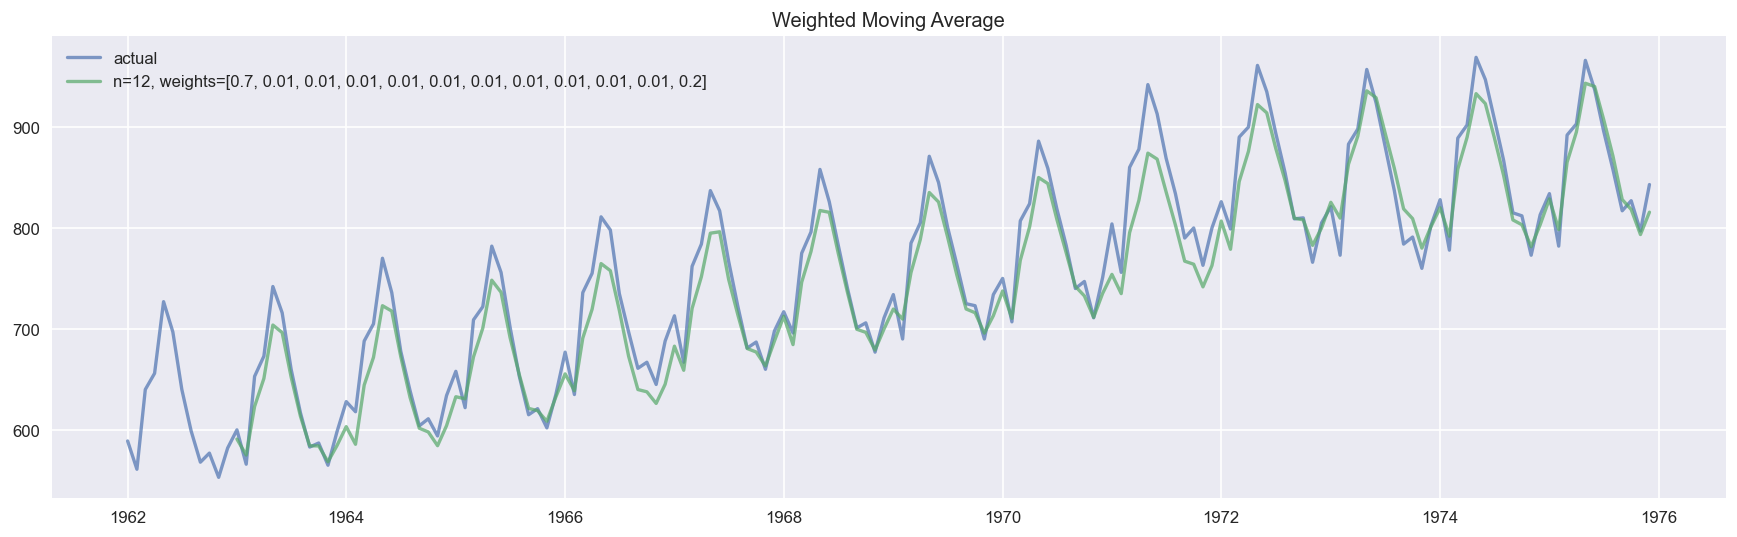

In [15]:
plt.plot(
    df['milk'],
    linewidth=2, 
    label='actual', 
    alpha=.7
)

plt.plot(
    weighted_moving_average_pred, 
    linewidth=2, 
    label=f'n={n_window}, weights={weights}',
    alpha=.7
)
plt.title('Weighted Moving Average')
plt.legend();

* Оптимальную развесовку можно попробовать найти через __optuna__, __scipy__, или описать поиск вручную

### 2.5 Автокорреляция

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

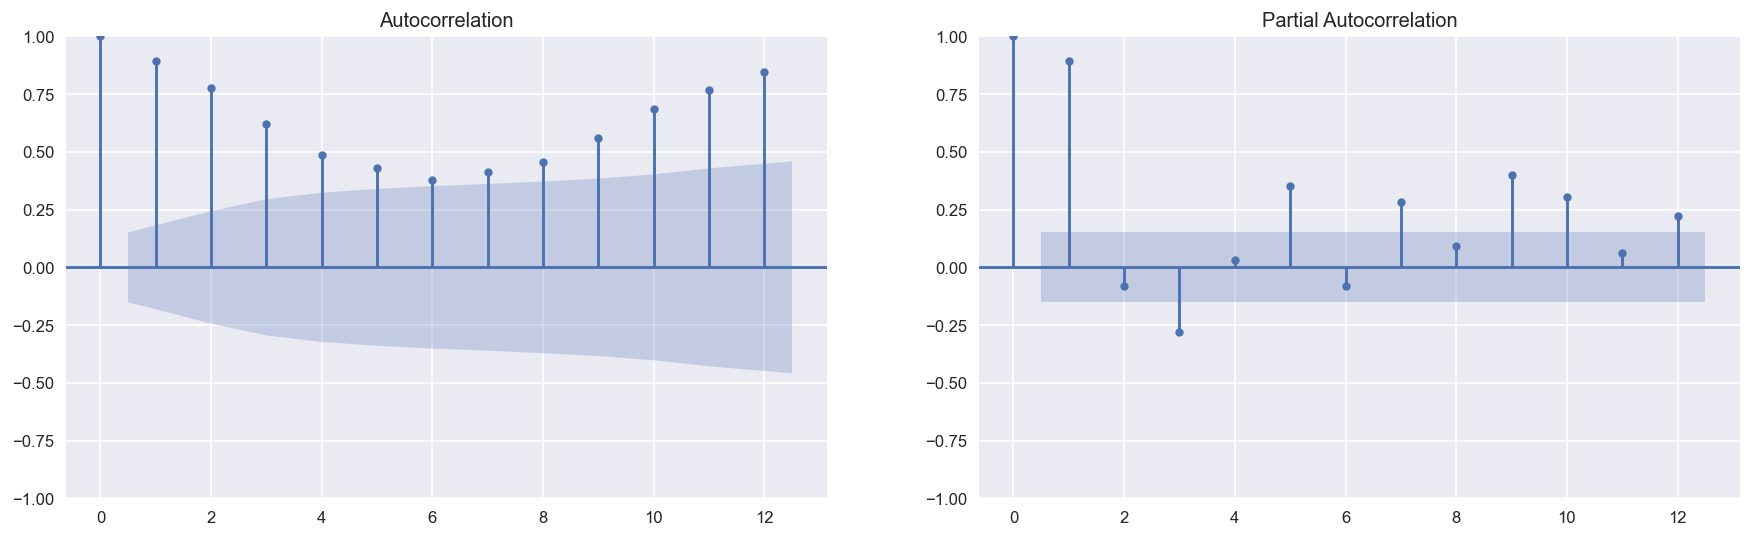

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
n_lags = 12
acf = plot_acf(df['milk'], ax=ax1, lags=n_lags)
pacf = plot_pacf(df['milk'], ax=ax2, lags=n_lags)

### 3. ARIMA class models

In [18]:
from statsmodels.tsa.ar_model import AutoReg

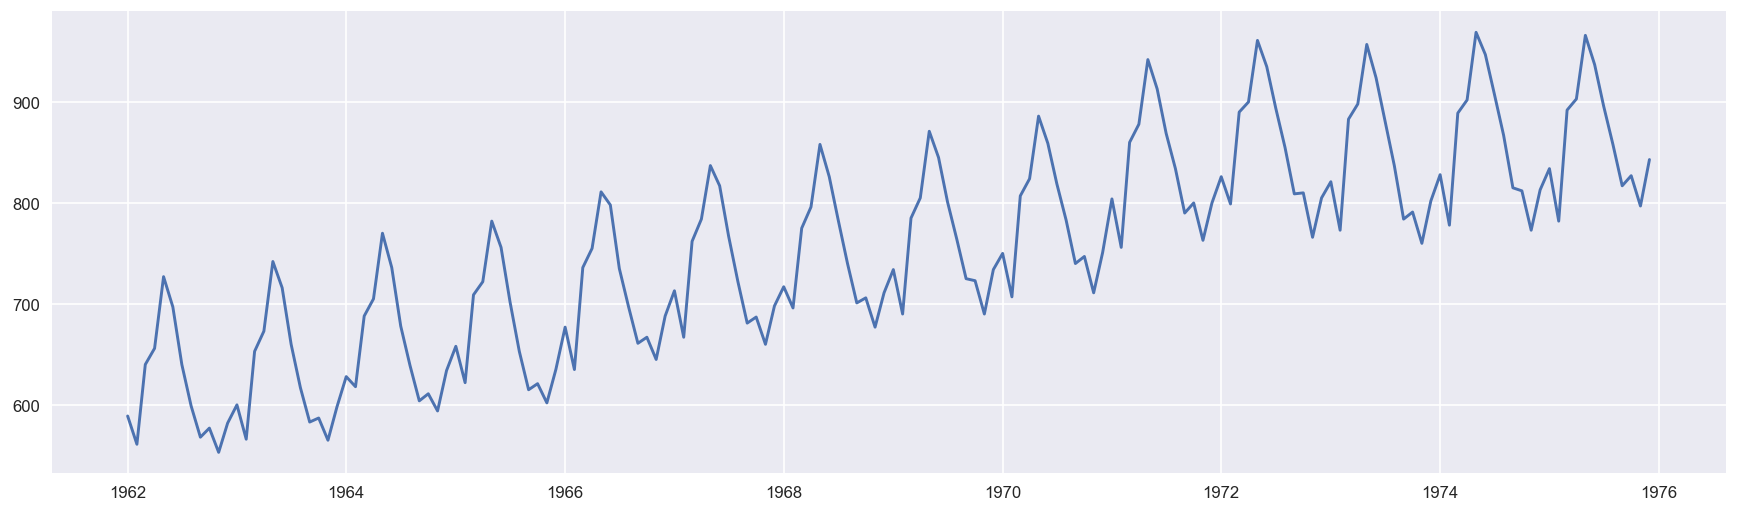

In [19]:
plt.plot(df['milk'])

In [20]:
data_train = df[df['milk'].index.year < 1974]
data_test = df[df['milk'].index.year >= 1974]

In [21]:
lags = 12

ar = AutoReg(data_train, lags=lags).fit()


seasonality_period = 12 
ar_pred_train = ar.fittedvalues # предсказания для train


ar_pred = ar.forecast(len(data_test) + 3 * seasonality_period) # Предсказание для тестовых точек + еще на 3 сезона вперед
ar_pred_test, ar_pred_future = ar_pred[:len(data_test)], ar_pred[len(data_test):] # Делим элементы из тестовой выборки и будущий периож


# plt.plot(
#     best_triple_exp.fittedvalues, 
#     label=f'\u03B1 = {alpha}, \u03B2 = {betta}, \u03B3 = {gamma}; RMSE={rmse}', marker='v', color='k')

ar_mae = round(mean_absolute_error(data_test, ar_pred_test), 3)
ar_r2 = round(r2_score(data_test, ar_pred_test), 3)
print(f'mae = {ar_mae}')
print(f'r2 = {ar_r2}')

mae = 12.585
r2 = 0.915


/Users/anton/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [22]:
display('Веса авторегрессии')
ar.params

'Веса авторегрессии'

const       38.482526
milk.L1      0.189520
milk.L2      0.042581
milk.L3     -0.059498
milk.L4     -0.044674
milk.L5      0.043710
milk.L6     -0.037217
milk.L7      0.057434
milk.L8     -0.082553
milk.L9      0.018573
milk.L10     0.087376
milk.L11    -0.034626
milk.L12     0.790472
dtype: float64

* самый большой вес имеет сезонный лаг(этот же месяц в прошлом году), а так же прошлый месяц

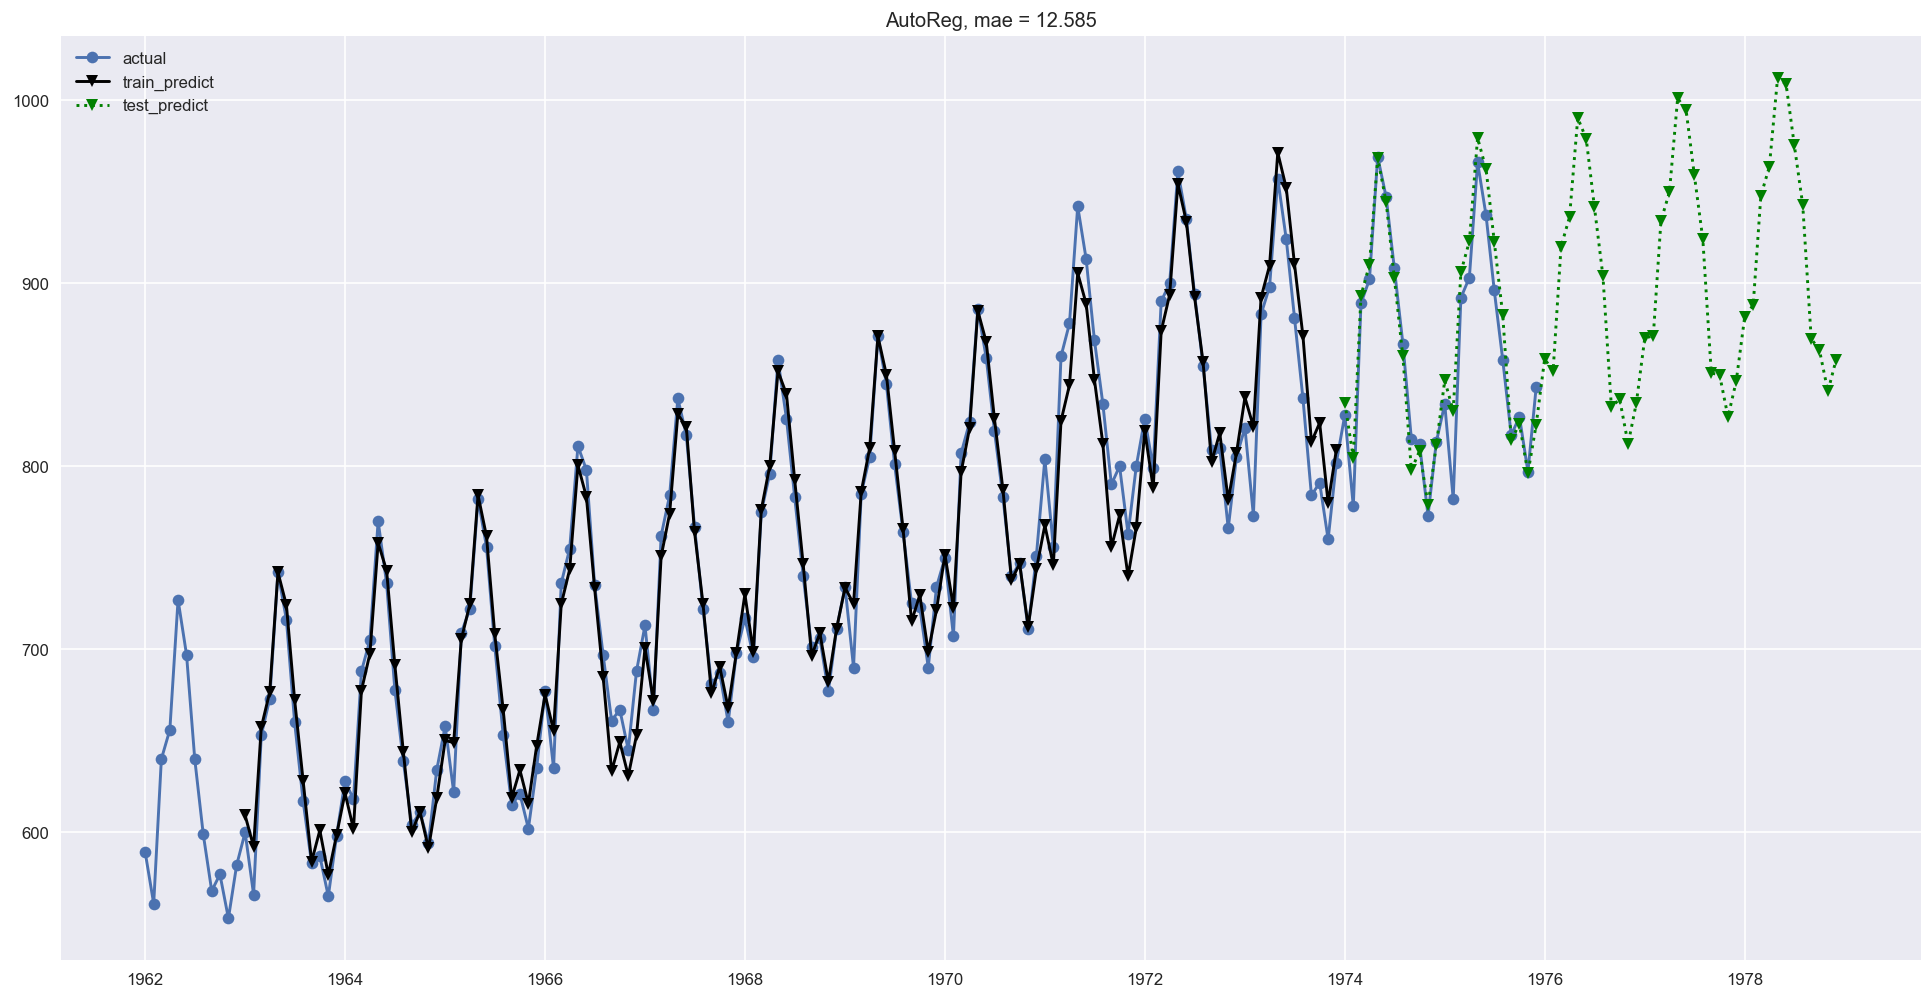

In [23]:
plt.figure(figsize=(20, 10))
plt.plot(df['milk'], label='actual', marker='o')
plt.plot(ar_pred_train, marker='v', color='k', label='train_predict')
plt.plot(pd.concat((ar_pred_test, ar_pred_future)), marker='v', color='g', label='test_predict', linestyle=':')
plt.legend()
plt.title(f'AutoReg, mae = {ar_mae}');

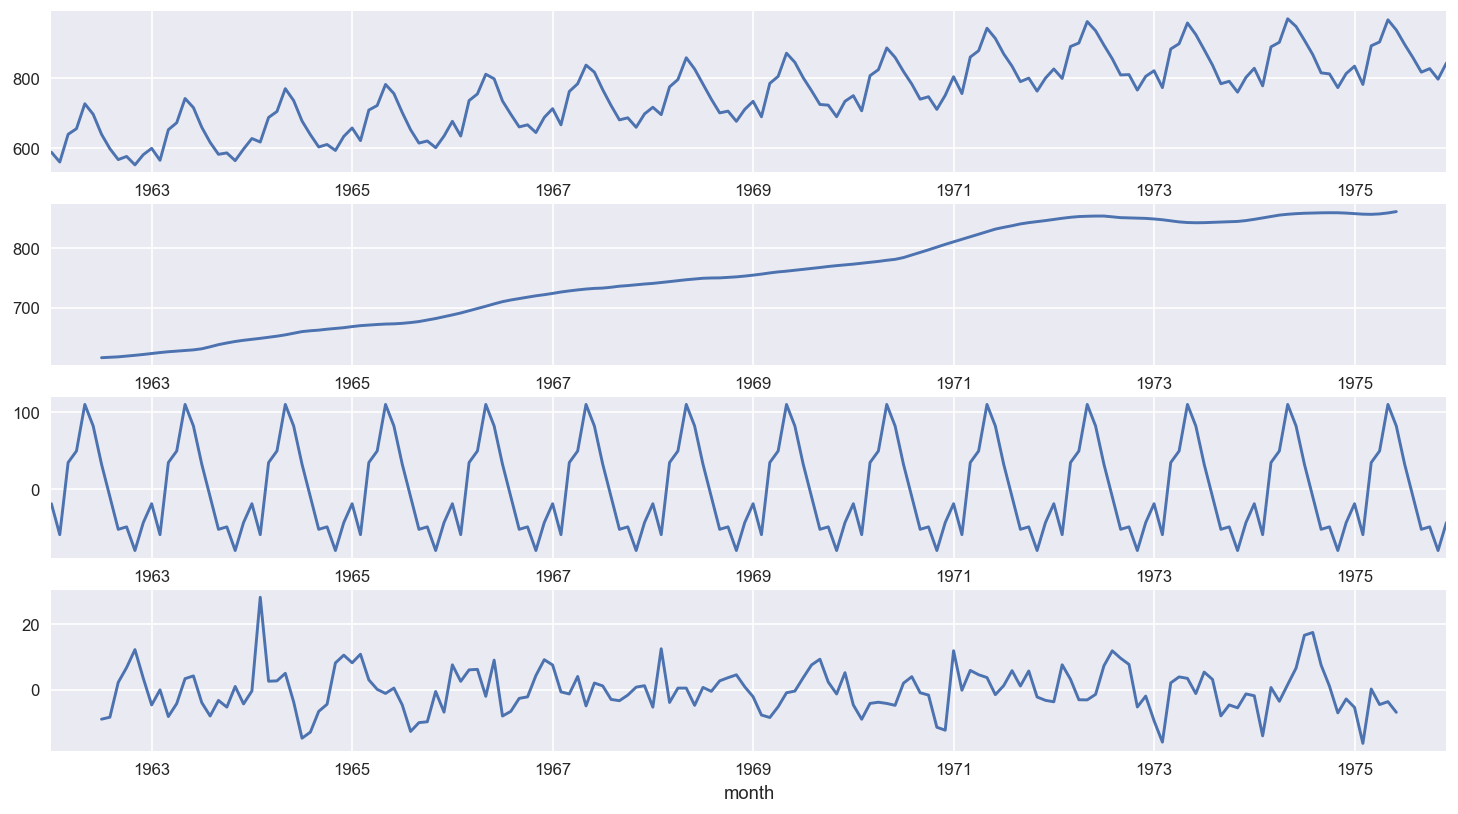

In [24]:
# Функция разложения временного ряда на тренд, компоненты сезонности и остатки (ошибки)
from statsmodels.tsa.seasonal import seasonal_decompose

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
res = seasonal_decompose(df['milk'])
res.observed.plot(ax=ax1)
res.trend.plot(ax=ax2)
res.seasonal.plot(ax=ax3)
res.resid.plot(ax=ax4)
plt.show();

### 4. Prophet

In [25]:
from prophet import Prophet

$y(t) = g(t) + s(t) + h(t) + \epsilon (t)$ 

$g(t)$ - трендовая компонента  
$s(t)$ - сезонная компонента  
$h(t)$ - компонента праздников или других всплесков  
$\epsilon (t)$ - остаток(шум)

* Одна из самых популярных моделей на текущей момент
* Не всегда проста в настраивании
* Вклад каждой из компонент будет расчитываться автоматически (не полезем вовнутрь, там ряды фурье😰)
* Некоторое воздействие на каждую из компонент все же есть
* [документация](https://facebook.github.io/prophet/docs/quick_start.html)

In [26]:
data_prophet = df['milk'].reset_index().rename(columns={'month': 'ds', 'milk': 'y'}) # Обязательное имена колнок с датой и таргетотм в prophet


data_train = data_prophet[data_prophet['ds'].dt.year < 1974]
data_test = data_prophet[data_prophet['ds'].dt.year >= 1974]

In [27]:
model = Prophet()
model.fit(data_train)

seasonality_period = 12 
number_of_future_predicted_points = 5 * seasonality_period # Предскажем на три периода в тесте + пару периодов наперед

future = model.make_future_dataframe(periods=number_of_future_predicted_points, freq='M')
forecast = model.predict(future)

08:41:45 - cmdstanpy - INFO - Chain [1] start processing
08:41:45 - cmdstanpy - INFO - Chain [1] done processing


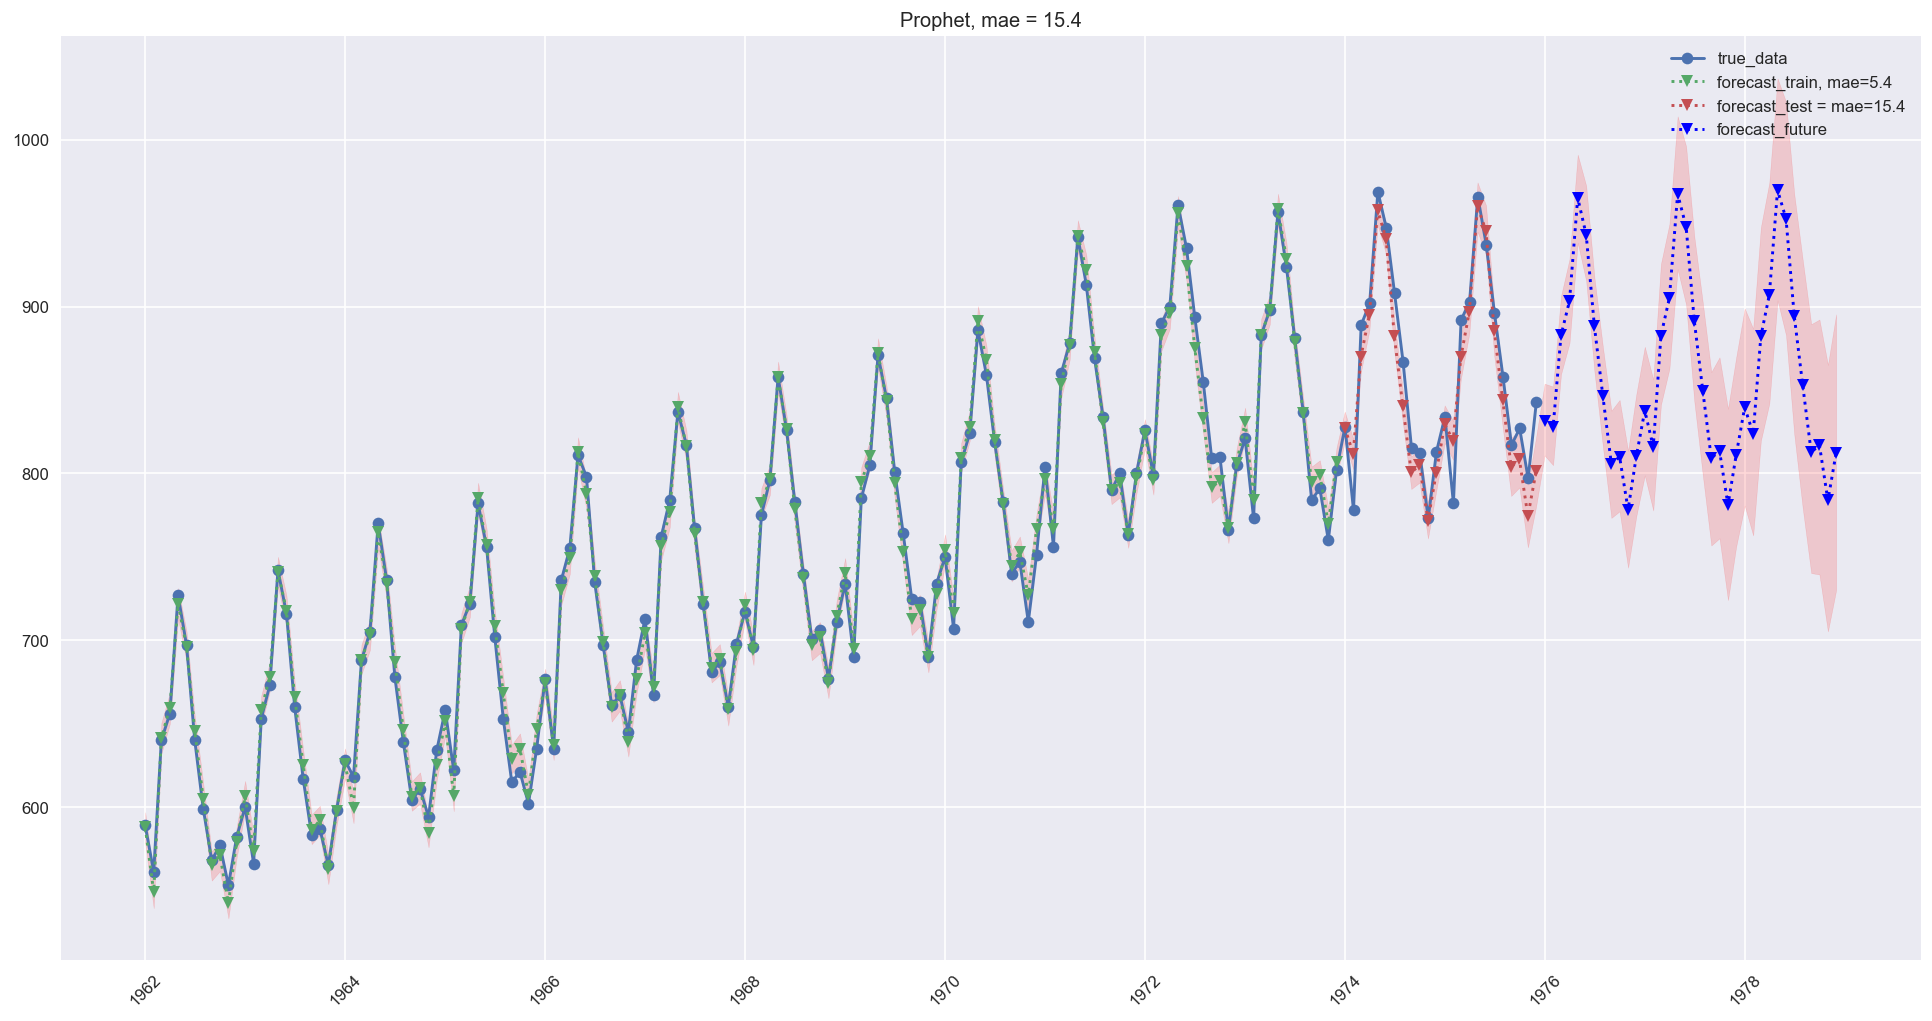

In [28]:
forecast_train = forecast[:-number_of_future_predicted_points] # Трейновый период
forecast_test = forecast[-number_of_future_predicted_points: -number_of_future_predicted_points + len(data_test)] # Тестовый
forecast_future = forecast[-number_of_future_predicted_points + len(data_test):] # Будущий период


prophet_mae_train = np.round(mean_absolute_error(data_train['y'], forecast_train['yhat']), 1)
prophet_mae_test = np.round(mean_absolute_error(data_test['y'], forecast_test['yhat']), 1)

plt.figure(figsize=(20, 10))
plt.plot(df['milk'], label='true_data', marker='o')

plt.plot(forecast_train['ds'], forecast_train['yhat'], marker='v', linestyle=':', label=f'forecast_train, mae={prophet_mae_train}')
plt.plot(forecast_test['ds'], forecast_test['yhat'], marker='v', linestyle=':', label=f'forecast_test = mae={prophet_mae_test}')
plt.plot(forecast_future['ds'], forecast_future['yhat'], marker='v', linestyle=':', label='forecast_future', color='b')

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.15)
plt.xticks(rotation=45)

plt.title(f'Prophet, mae = {prophet_mae_test}');
plt.legend();

In [29]:
import itertools
import logging

logging.getLogger('cmdstanpy').setLevel(logging.ERROR) # Выключение логов

param_grid = {  
    'changepoint_prior_scale': list(np.arange(0.01, 0.5, 0.04)),
    'seasonality_prior_scale': list(np.arange(1, 10, 0.5)),
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAEs for each params here

# Use validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params).fit(data_train)  # Обучаем модель с заданными параметрами
    future = model.make_future_dataframe(periods=number_of_future_predicted_points, freq='M')  # Создаем фрейм данных для будущего (для тестовой выборки)
    forecast = model.predict(future)  # Делаем предсказание на будущее
    forecast_test = forecast[-number_of_future_predicted_points: -number_of_future_predicted_points + len(data_test)]
    prophet_mae_test = np.round(mean_absolute_error(data_test['y'], forecast_test['yhat']), 1)
    maes.append(prophet_mae_test)  # Добавляем RMSE для данного набора параметров

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['maes'] = maes

In [30]:
tuning_results.sort_values(by='maes')

,changepoint_prior_scale,seasonality_prior_scale,maes
19,0.05,1.5,15.0
34,0.05,9.0,15.0
29,0.05,6.5,15.1
22,0.05,3.0,15.1
24,0.05,4.0,15.2
...,...,...,...
4,0.01,3.0,29.9
0,0.01,1.0,29.9
7,0.01,4.5,30.2
17,0.01,9.5,30.8


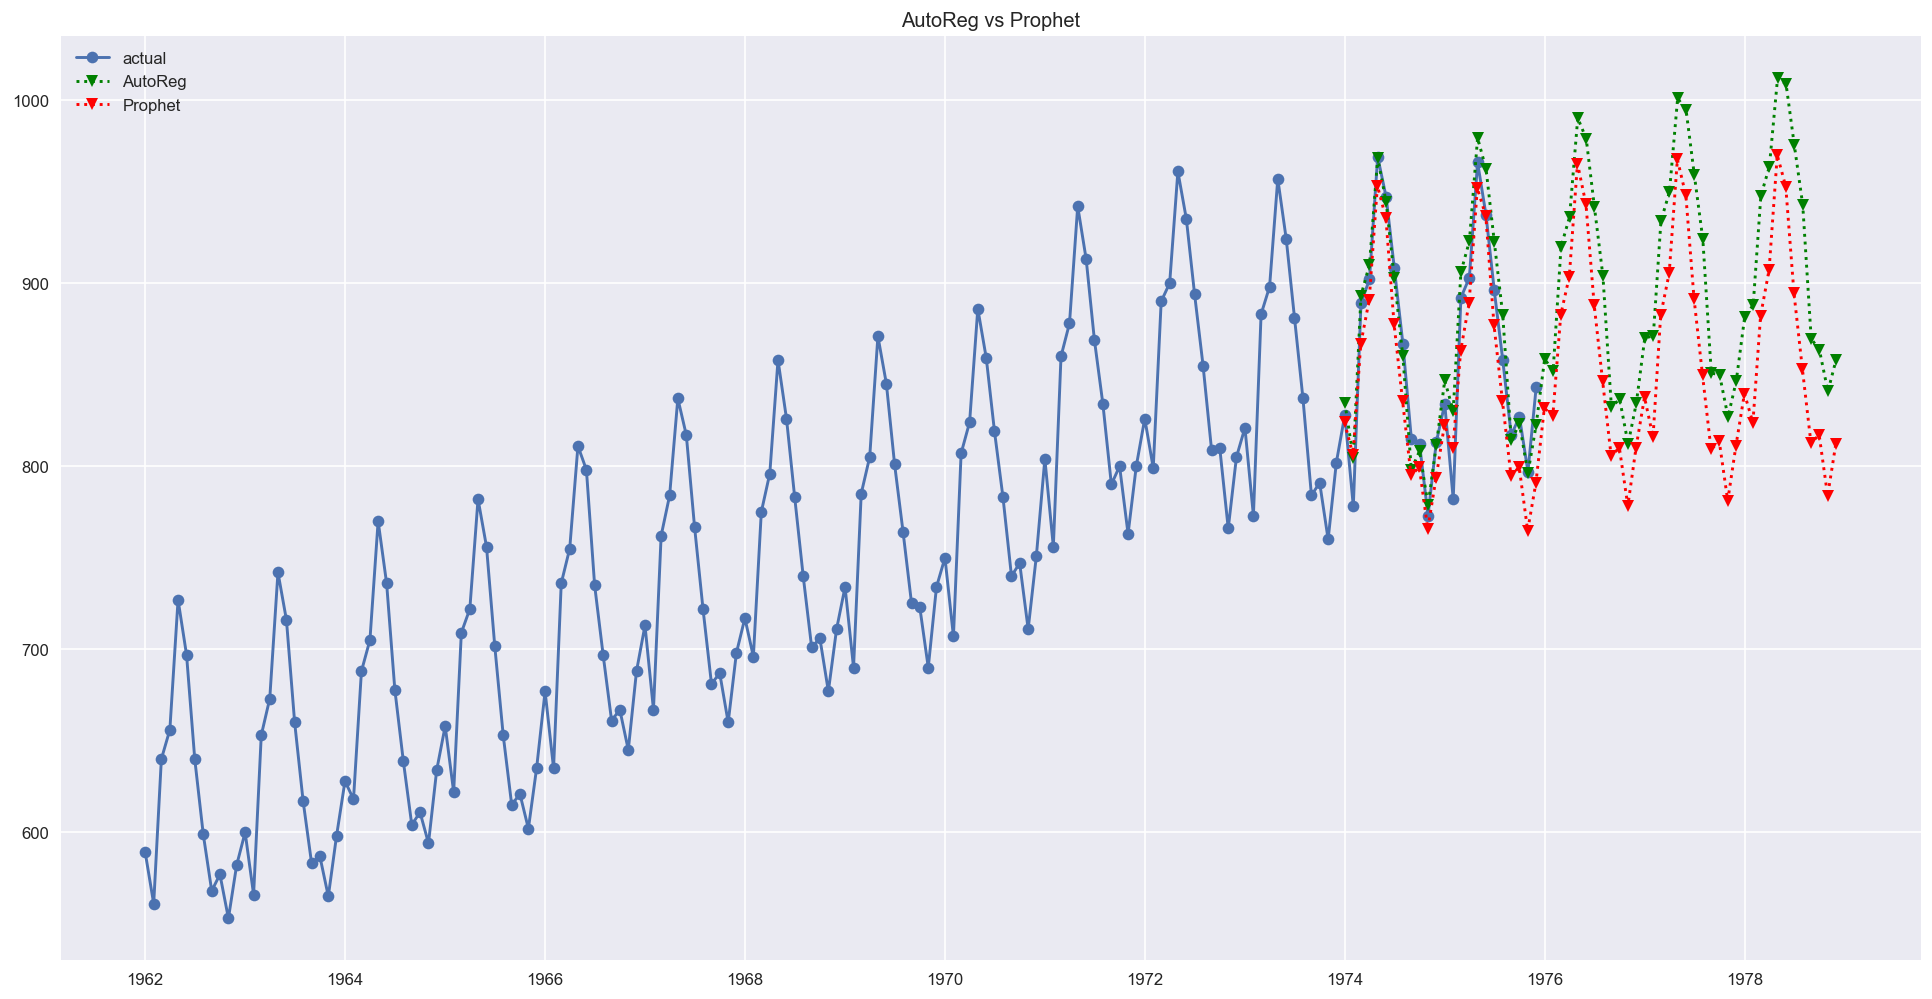

In [31]:
plt.figure(figsize=(20, 10))
plt.plot(df['milk'], label='actual', marker='o')
plt.plot(pd.concat((ar_pred_test, ar_pred_future)), marker='v', color='g', linestyle=':', label='AutoReg')
plt.plot(pd.concat((forecast_test, forecast_future))['ds'], pd.concat((forecast_test, forecast_future))['yhat'], marker='v', color='r', linestyle=':', label='Prophet')
# plt.plot(triple_exp_fcast, color='r', label= f'TripleExp rmse = {triple_exp_rmse}')
# plt.plot(ar_fcast, color='g', label = f'AutoReg rmse = {ar_rmse}')


plt.legend()
plt.title(f'AutoReg vs Prophet');

### 4. Итог

In [32]:
rmse_models_list = [moving_average_mae, weighted_moving_average_mae, ar_mae, prophet_mae_test]
rmse_list = pd.Series(
    index = ['Moving_average', 'Weighted_moving_average', 'AutoReg', 'Prophet'], 
    data=rmse_models_list
)

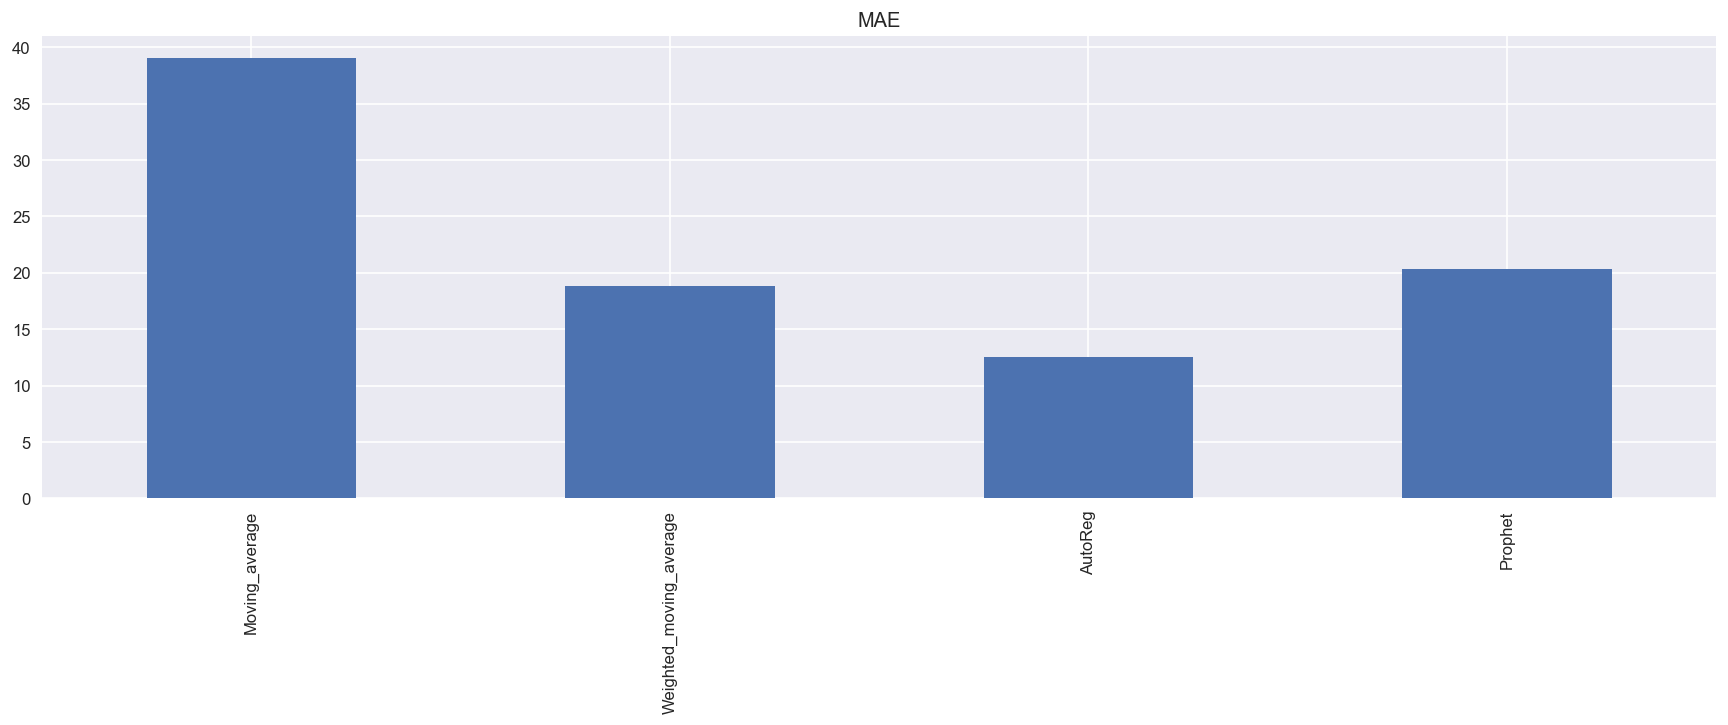

In [33]:
rmse_list.plot.bar()
plt.title('MAE');

Еще ряд сильных библиотек по работе с временными рядами:  
* [Darts](https://habr.com/ru/articles/659405/)
* [Merlion](https://habr.com/ru/companies/sportmaster_lab/articles/792318/)
* [tsfresh](https://tsfresh.readthedocs.io/en/latest/)
* [Kats](https://github.com/facebookresearch/Kats)
* [autots](https://winedarksea.github.io/AutoTS/build/html/source/tutorial.html)